# Title

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rcParams
from string import ascii_lowercase
import ipywidgets
import time

import discretize
from SimPEG import (
    Utils, Maps, Inversion, Regularization, DataMisfit, InvProblem,
    Optimization, Directives
)
from SimPEG import DC
from SimPEG.EM import TDEM
from pymatsolver import Pardiso

import casingSimulations as casingSim

%matplotlib inline

In [2]:
rcParams['font.size'] = 14

In [3]:
sim_dir = 'DC_halfspace'

## Model

- approximate the casing as a solid cylinder, conductivity equals to the conductivity thickness product
- use effective medium theory to estimate the conductivity of the target

In [4]:
# casing parameters
casing_l = 1000
sigma_back = 1e-2
casing_d = 10e-2
casing_t = 1e-2
sigma_casing = 5e6

sigma_casing_homogenized = sigma_casing * np.pi*((casing_d/2)**2 - (casing_d/2 - casing_t)**2)
print('The conductivity of the cylinder is {:1.2e} S/m'.format(sigma_casing_homogenized))

The conductivity of the cylinder is 1.41e+04 S/m


In [5]:
# proppant-fluid parameters
sigma_proppant = 1e4
sigma_fluid = 3
phi_proppant = 0.5

In [6]:
scemt = Maps.SelfConsistentEffectiveMedium(sigma0=sigma_fluid, sigma1=sigma_proppant)
sigma_pf = (scemt * np.r_[phi_proppant])[0]
print('The conductivity of the proppant-fluid mixture is {:1.2f} S/m'.format(sigma_pf))

The conductivity of the proppant-fluid mixture is 2506.73 S/m


In [7]:
# fracture geometry
n_fracs = 10
fracture_thickness = 3e-3
fracture_width = 10. # 10m wide fracture zone
fracture_radius = 50.
fracture_top = -950.

In [8]:
V_total = np.pi * fracture_radius**2 * fracture_width 
V_frac = np.pi * fracture_radius**2 * fracture_thickness*n_fracs
phi_frac = V_frac/V_total

print("The concentration of fractures by volume is {}".format(phi_frac))

The concentration of fractures by volume is 0.003


In [9]:
alpha = (fracture_thickness*0.5)/50

print("We assume an aspect ratio of {}".format(alpha))

We assume an aspect ratio of 3e-05


In [10]:
scemt_fractures = Maps.SelfConsistentEffectiveMedium(
    sigma0=sigma_back, sigma1=sigma_pf, alpha1=alpha
)

In [11]:
sigma_frac = (scemt_fractures * np.r_[phi_frac])[0]
print('The conductivity of the fractured region of rock is {:1.2f} S/m'.format(sigma_frac))

The conductivity of the fractured region of rock is 3.31 S/m


In [30]:
model = casingSim.model.CasingInHalfspaceWithTarget(
    directory=sim_dir,
    sigma_casing= sigma_casing_homogenized,  # conductivity of the casing (S/m)
    sigma_back = sigma_back,  # conductivity of the background (S/m)
    sigma_inside = sigma_casing_homogenized,  # fluid inside the well has same conductivity as the background
    sigma_air = 1e-4,   # conductivity of the air
    sigma_target = sigma_frac,  # conductivity of the fractured region
    casing_d = casing_d-casing_d/2,  # 10 cm is outer casing diameter
    casing_l = casing_l,
    casing_t = casing_d/4, 
    target_radius = np.r_[0., fracture_radius],
    target_z = fracture_top + np.r_[-fracture_width, 0.],
    src_a = np.r_[0., np.pi, -975.],  # put the A electrode just below the surface
    src_b = np.r_[2000., np.pi, -1.25] # put the return electrode at a distance of 2 x length of well away
)

In [31]:
model.serialize()

{'__class__': 'CasingInHalfspaceWithTarget',
 'casing_d': 0.05,
 'casing_l': 1000.0,
 'casing_t': 0.025,
 'casing_top': 0.0,
 'directory': 'DC_halfspace',
 'filename': 'ModelParameters.json',
 'mur_back': 1.0,
 'mur_casing': 1.0,
 'sigma_air': 0.0001,
 'sigma_back': 0.01,
 'sigma_casing': 14137.166941154077,
 'sigma_inside': 14137.166941154077,
 'sigma_target': 3.306452089817292,
 'src_a': [0.0, 3.141592653589793, -975.0],
 'src_b': [2000.0, 3.141592653589793, -1.25],
 'surface_z': 0.0,
 'target_radius': [0.0, 50.0],
 'target_theta': [0.0, 6.283185307179586],
 'target_z': [-960.0, -950.0],
 'version': '0.0.6'}

In [32]:
copied_model_params = copiedmodelparams = {
    key: val for key, val in model.serialize().items() 
    if key in dir(casingSim.model.CasingInHalfspace) and not key.startswith('_') 
}
background = casingSim.model.CasingInHalfspace(**copied_model_params)

In [33]:
model_names = ["background", "fracture"]
model_dict = {
    "background": background, 
    "fracture": model
}

## Mesh

In [34]:
# parameters defining the core region of the mesh
# note that the finest re
csx2 = 25.  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = 2.5  # cell size in the z-direction 
domainx2 = 1000  # go out 500m from the well

# padding parameters
npadx, npadz = 9, 16  # number of padding cells
pfx2 = 1.5  # expansion factor for the padding to infinity in the x-direction
pfz = 1.5

# discretization in theta
# hy = utils.meshTensor([(1, 2, -1.5), (1, 3), (1, 2, 1.5)])
hy = np.ones(12)
hy = hy*2*np.pi / hy.sum()

# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
cylMeshGen = casingSim.CasingMeshGenerator(
    directory=sim_dir,  # directory where we can save things
    modelParameters=model,  # casing parameters
    npadx=npadx,  # number of padding cells in the x-direction
    npadz=npadz,  # number of padding cells in the z-direction
    domain_x=domainx2,  # extent of the second uniform region of the mesh 
    hy=hy,   # cell spacings in the 
    csx1=model.casing_b/4.,  # use at least 4 cells per across the thickness of the casing
    csx2=csx2,  # second core cell size
    csz=csz,  # cell size in the z-direction
    pfx1=1.2, 
    pfx2=pfx2,  # padding factor to "infinity"
    pfz=pfz  # padding factor to "infinity" for the z-direction
)
mesh = cylMeshGen.mesh

In [35]:
print("The mesh has {} cells".format(mesh.nC))

The mesh has 519792 cells


/anaconda3/lib/python3.6/site-packages/matplotlib/projections/polar.py:58: RuntimeWarning: invalid value encountered in less
  mask = r < 0


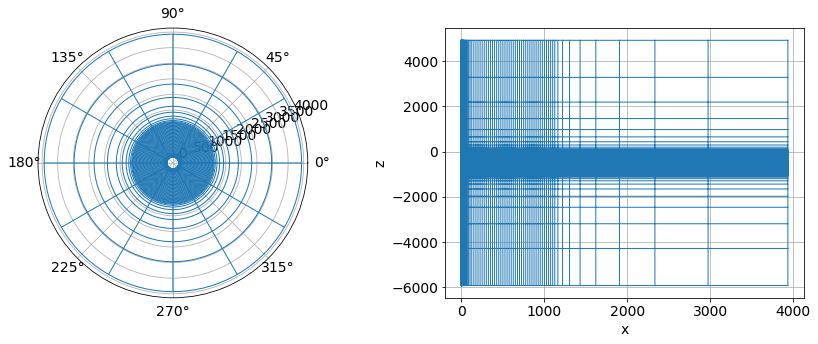

In [36]:
cylMeshGen.mesh.plotGrid()

## Physical Properties

In [37]:
phys_props_dict = {
    key: casingSim.model.PhysicalProperties(cylMeshGen, val) for key, val in model_dict.items()
}

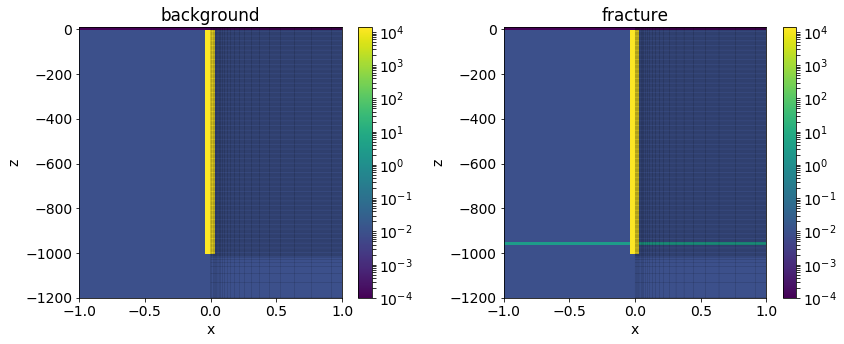

In [38]:
fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5))
xlim = 1*np.r_[-1, 1]
ylim = [-1200, 10]
plot_mesh = True

for a, key in zip(ax, model_names):
    phys_props_dict[key].plot_sigma(ax=a, pcolorOpts={'norm':LogNorm()})
    a.set_xlim(xlim)
    a.set_ylim(ylim)
    a.set_title(key)

    if plot_mesh:
        mesh.plotGrid(ax=a, line_width=0.1, line_color='k', slice="theta")
        a.grid(None)

plt.tight_layout()

## Survey

In [54]:
# rotate source so it is on a cell center perpendicular to the receivers
src_theta = mesh.vectorCCy[3]
src_a = model.src_a
src_b = model.src_b

src_a[1] = src_theta
src_b[1] = src_theta

print(src_a, src_b)

[   0.            1.83259571 -975.        ] [ 2.00000000e+03  1.83259571e+00 -1.25000000e+00]


In [55]:
rx_x = np.linspace(25, 1000, 40)
rx_z = np.r_[-1.25]  # slightly below the surface for better interpolation 

rx_locs = Utils.ndgrid([rx_x, np.r_[mesh.vectorCCy[0]], rx_z])

rx_list = [DC.Rx.BaseRx(rx_locs, 'ex')]

In [56]:
src_list = [DC.Src.Dipole(rx_list, locA=src_a, locB=src_b)]

## Set up a DC simulation

In [57]:
prob_dict = {}
survey_dict = {}

for key in model_names:
    prob_dict[key] = DC.Problem3D_CC(
        mesh, sigmaMap=Maps.ExpMap(mesh), bc_type='Dirichlet', Solver=Pardiso
    )
    survey_dict[key] = DC.Survey(src_list)
    prob_dict[key].pair(survey_dict[key]) 

Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.


In [58]:
%%time
fields_dict = {}
for key in model_names:
    t = time.time()
    print('Running {}'.format(key))
    fields_dict[key] = prob_dict[key].fields(np.log(phys_props_dict[key].sigma))
    print('  ... elapsed time {:1.2e} s\n'.format(time.time()-t))

Running background
  ... elapsed time 2.32e+01 s

Running fracture
  ... elapsed time 2.76e+01 s

CPU times: user 1min 5s, sys: 4.23 s, total: 1min 9s
Wall time: 50.8 s


In [59]:
%%time
data_dict = {}
for key in model_names:
    t = time.time()
    print('Computing data for {}'.format(key))
    data_dict[key] = survey_dict[key].dpred(
        np.log(phys_props_dict[key].sigma), f=fields_dict[key]
    )
    print('  ... elapsed time {:1.2e} s\n'.format(time.time()-t))

Computing data for background


/Users/lindseyjh/git/python_symlinks/discretize/CylMesh.py:1540: RuntimeWarning: divide by zero encountered in true_divide
  weights = 1./d  # d**2?


  ... elapsed time 1.57e+00 s

Computing data for fracture
  ... elapsed time 4.04e-01 s

CPU times: user 1.32 s, sys: 456 ms, total: 1.78 s
Wall time: 1.97 s


## Plot data

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


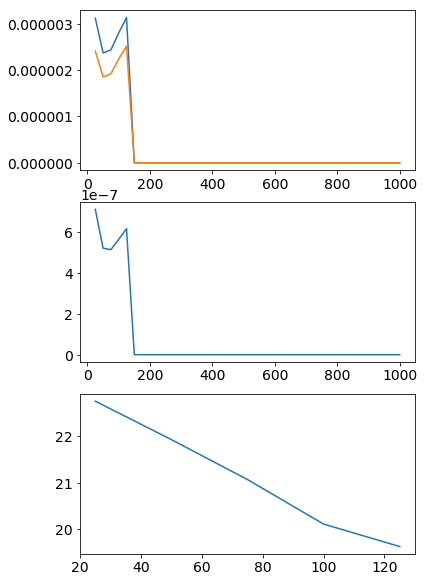

In [60]:
fig, ax = plt.subplots(3, 1, figsize=(6, 10))

[ax[0].plot(rx_x, data_dict[key], label=key) for key in model_names]
ax[1].plot(rx_x, np.absolute(data_dict["fracture"] - data_dict["background"]), label=key)
ax[2].plot(rx_x, 100*np.absolute(data_dict["fracture"] - data_dict["background"])/data_dict["background"], label=key)

## Set up an inversion

In [61]:
# Construct mapping
ExpMap = Maps.ExpMap(mesh)
ind_inactive = (mesh.gridCC[:,2] > 0) | model.ind_casing(mesh)
sigma_inactive = phys_props_dict["background"].sigma[ind_inactive]
InjectInactiveCells = Maps.InjectActiveCells(mesh, ~ind_inactive, np.log(sigma_inactive))
mapping = ExpMap * InjectInactiveCells

In [ ]:
prob_inv = DC.Problem3D_CC(
    mesh, sigmaMap=mapping, bc_type='Dirichlet', Solver=Pardiso
)
survey_inv = DC.Survey(src_list)
prob_inv.pair(survey_inv) 

In [ ]:
survey_inv.dobs = data_dict["fracture"]
survey_inv.std = 0.01
survey_inv.eps = 1e-8

In [ ]:
regmesh = discretize.TensorMesh([mesh.hx, mesh.hz], x0=np.r_[mesh.x0[[0, 2]]])
reg = Regularization.Tikhonov(regmesh, alpha_s=1e-1, indActive=~ind_inactive)
dmis = DataMisfit.l2_DataMisfit(survey_inv)
opt = Optimization.InexactGaussNewton(maxIterCG=10, maxIter=10, remember='xc')
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
directives = [
    Directives.BetaEstimate_ByEig(beta0_ratio=2),
    Directives.BetaSchedule(coolingFactor=8, coolingRate=3),
    Directives.SaveOutputEveryIteration(),
    Directives.SaveModelEveryIteration(),
#     Directives.TargetMisfit()
]
inv = Inversion.BaseInversion(invProb, directiveList=directives)

In [ ]:
mapping.nP

In [ ]:
mesh.nC

In [ ]:
m0 = np.log(sigma_back * np.ones(mapping.nP))

In [ ]:
%%time
mrec = inv.run(m0)

In [ ]:
fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5))
xlim = 5*np.r_[-1, 1]
ylim = [-1050, -600]
clim = [sigma_back, np.exp(mrec.max())]
plot_mesh = False

out_true = phys_props_dict[key].plot_sigma(
    ax=ax[0], pcolorOpts={'norm':LogNorm()}, clim=clim
)
out_rec = phys_props_dict[key].plot_prop(
    mapping * mrec, ax=ax[1], pcolorOpts={'norm':LogNorm()}, clim=clim
)

# out_true[-1].set_clim(clim)
# out_rec[-1].set_clim(clim)

# out_true[-1].update_ticks()
# out_rec[-1].update_ticks()
for a in ax:
    a.set_xlim(xlim)
    a.set_ylim(ylim)
    a.set_title(key)

    if plot_mesh:
        mesh.plotGrid(ax=a, line_width=0.1, line_color='k', slice="theta")
        a.grid(None)

plt.tight_layout()

In [ ]:
# Sparse inversion

In [ ]:
regmesh = discretize.TensorMesh([mesh.hx, mesh.hz], x0=np.r_[mesh.x0[[0, 2]]])
# reg = Regularization.Tikhonov(regmesh, alpha_s=1e-1, indActive=~ind_inactive)
reg = Regularization.Sparse(
    regmesh, indActive=~ind_inactive,
    gradientType='components', 
    mapping=Maps.IdentityMap(nP=(~ind_inactive).sum()),
    alpha_s=1e-1
)
#     gradientType = 'components'
reg.norms = np.c_[0., 2., 2., 2.]
IRLS = Directives.Update_IRLS(
    maxIRLSiter=20, minGNiter=1,
    betaSearch=True, fix_Jmatrix=True
)
dmis = DataMisfit.l2_DataMisfit(survey_inv)
opt = Optimization.InexactGaussNewton(maxIterCG=10, maxIter=30, remember='xc')
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
directives = [
    Directives.BetaEstimate_ByEig(beta0_ratio=2),
    Directives.BetaSchedule(coolingFactor=8, coolingRate=3),
    Directives.SaveOutputEveryIteration(),
    Directives.SaveModelEveryIteration(),
    IRLS
#     Directives.TargetMisfit()
]
inv = Inversion.BaseInversion(invProb, directiveList=directives)

In [ ]:
%%time
mrec_sparse = inv.run(m0)

In [ ]:
fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5))
xlim = 200*np.r_[-1, 1]
ylim = [-1200, 0]
clim = [sigma_back, np.exp(mrec_sparse.max())]
plot_mesh = False

out_true = phys_props_dict[key].plot_sigma(
    ax=ax[0], pcolorOpts={'norm':LogNorm()}, clim=clim
)
out_rec = phys_props_dict[key].plot_prop(
    mapping * mrec_sparse, ax=ax[1], pcolorOpts={'norm':LogNorm()}, clim=clim
)

for a in ax:
    a.set_xlim(xlim)
    a.set_ylim(ylim)
    a.set_title(key)

    if plot_mesh:
        mesh.plotGrid(ax=a, line_width=0.1, line_color='k', slice="theta")
        a.grid(None)

plt.tight_layout()

## TDEM simulation

In [ ]:
timeSteps = [
    (1e-6, 20), (1e-5, 30), (3e-5, 30), (1e-4, 40), (3e-4, 30), (1e-3, 20), (3e-3, 20), (1e-2, 20), (3e-2, 20), (1e-1, 32)
]

In [ ]:
mesh

In [ ]:
prob_tdem = TDEM.Problem3D_j(
    mesh=mesh, sigmaMap=Maps.IdentityMap(mesh=mesh), timeSteps=timeSteps, Solver=Pardiso
)

In [ ]:
prob_tdem.times.max()

In [ ]:
casing_src = casingSim.sources.DownHoleTerminatingSrc(
    directory=sim_dir, 
    modelParameters=model, 
    meshGenerator=cylMeshGen,
    physics="TDEM"
)

In [ ]:
srcList = casing_src.srcList
rx_times = np.logspace(-6, np.log10(4), 100)
for src in srcList:
    src.rxList = [TDEM.Rx.Point_e(rx_locs, orientation="x", times=rx_times)]

In [ ]:
survey_tdem = TDEM.Survey(srcList)

In [ ]:
prob_tdem.pair(survey_tdem)

In [ ]:
%%time
fields_tdem = {}

for key in model_names: 
    t = time.time()
    print("Running {} ...".format(key))
    fields_tdem[key] = prob_tdem.fields(phys_props_dict[key].sigma)
    print("... elapsed time {:1.2e}".format(time.time()-t))

In [ ]:
%%time
dpred_tdem = {}

for key in model_names: 
    t = time.time()
    print("Running {} ...".format(key))
    dpred_tdem[key] = survey_tdem.dpred(phys_props_dict[key].sigma, f=fields_tdem[key])
    print("... elapsed time {:1.2e}".format(time.time()-t))

In [ ]:
for key, value in dpred_tdem.items():
    dpred_tdem[key] = value.reshape(len(rx_times), len(rx_x), order="F")

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(6, 10))

for i, offset in enumerate([rx_x[39]]):
    ax[0].plot(
        rx_times, (dpred_tdem["background"][:, i]), color="k".format(i if i < 10 else np.mod(i, 10))
    )
    ax[0].plot(
        rx_times, (dpred_tdem["fracture"][:, i]), color="C{}".format(i if i < 10 else np.mod(i, 10)), 
        linestyle="--"
    )
    
    ax[1].plot(
        rx_times, (dpred_tdem["fracture"][:, i] - dpred_tdem["background"][:, i]), 
        color="C{}".format(i if i < 10 else np.mod(i, 10))
    )
    ax[2].plot(
        rx_times, 100*(dpred_tdem["fracture"][:, i] - dpred_tdem["background"][:, i])/np.absolute(dpred_tdem["background"][:, i]), 
        color="C{}".format(i if i < 10 else np.mod(i, 10))
    )



In [ ]:
len(rx_locs)